In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pylab as plt
from scipy.linalg import block_diag
from scipy.optimize import minimize
data = sio.loadmat('data_for_cell77')

In [2]:
def pos_map(pos, nbins, boxSize):
    #discretize the position into different bins
    # pos: nx2 matrix
    bins = np.arange(boxSize/nbins,boxSize,boxSize/nbins)
    xcoord = np.digitize(pos[:,0],bins)
    ycoord = np.digitize(pos[:,1],bins)
    coord = (xcoord)*nbins+(nbins-ycoord-1) #make x and y start form the top left corner
    
    output = np.zeros((pos.shape[0],nbins**2))
    output[np.arange(pos.shape[0]),coord]=1
    
    return (output,bins)

posc=np.hstack([data['posx_c'],data['posy_c']])
(posgrid, posVec)=pos_map(posc,20,100)
posgrid.shape

(145150, 400)

In [3]:
def hd_map(posx,posx2,posy,posy2,nbins):
    direction = np.arctan2(posy2-posy,posx2-posx)+np.pi/2
    direction[direction<0] = direction[direction<0]+2*np.pi
    direction = direction.ravel() #change to 1d array
    
    hd_grid = np.zeros((posx.shape[0],nbins))
    dirVec = np.arange(2*np.pi/nbins,2*np.pi,2*np.pi/nbins)
    idx = np.digitize(direction,dirVec)
    hd_grid[np.arange(posx.shape[0]),idx]=1
    
    return (hd_grid,dirVec,direction)

(hdgrid,dirVec,direction) = hd_map(data['posx'],data['posx2'],data['posy'],data['posy2'],18)



In [4]:
def speed_map(posx,posy,nbins,sampleRate=50,maxSpeed=50):
    velx = np.diff(np.insert(posx,0,posx[0]));   
    vely = np.diff(np.insert(posy,0,posy[0]));
    speed = np.sqrt(velx**2+vely**2)*sampleRate; 
    speed[speed>maxSpeed] = maxSpeed; #send everything over 50 cm/s to 50 cm/s
    
    speedVec = np.arange(maxSpeed/nbins,maxSpeed,maxSpeed/nbins)
    speed_grid = np.zeros((posx.shape[0],nbins))
    
    idx = np.digitize(speed,speedVec)
    speed_grid[np.arange(speed.shape[0]),idx.ravel()]=1
    
    return (speed_grid,speedVec,speed,idx)

(speedgrid,speedVec,speed,idx) = speed_map(data['posx_c'],data['posy_c'],10)

In [5]:
too_fast = np.where(speed>=50)
posgrid = np.delete(posgrid,too_fast,axis=0)
speedgrid = np.delete(speedgrid,too_fast,axis=0)
hdgrid = np.delete(hdgrid,too_fast,axis=0)
spiketrain = np.delete(data['spiketrain'],too_fast,axis=0)

In [6]:
#Smooth firing rate
def gaussfilter(x,mu,sigma):
    a=np.exp(-(x-mu)**2/(2*sigma**2))
    a = a/a.sum(axis=0)
    return a

f = gaussfilter(np.arange(-4,5),0,2)
post = data['post']
dt = post[3]-post[2]
fr = data['spiketrain'].ravel()/dt
print(fr.shape)
smooth_fr = np.convolve(fr,f,mode='same')

(145150,)


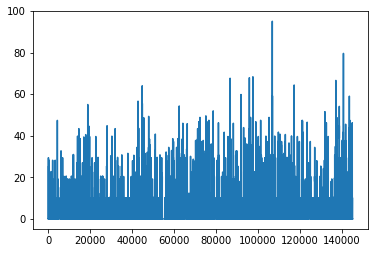

In [7]:
plt.plot(smooth_fr)

In [13]:
def ln_poisson_model(param,X,Y,modelType=None):
    #X: navigation variables, Y: spiketrain
    u = X*np.matrix(param).T
    rate = np.exp(u)
    
    # roughness regularizer weight - note: these are tuned using the sum of f,
    # and thus have decreasing influence with increasing amounts of data
    b_pos = 8e0; 
    b_hd = 5e1; 
    b_spd = 5e1; 
    b_th = 5e1;
    
#     rX = np.multiply(rate,X)
#     hessian_glm = rX.T*X #matrix multiply
    
    # initialize parameter-relevant variables
    J_pos = 0; J_pos_g = []; J_pos_h = []; 
    J_hd = 0; J_hd_g = []; J_hd_h = [];  
    J_spd = 0; J_spd_g = []; J_spd_h = [];  
    J_theta = 0; J_theta_g = []; J_theta_h = []; 
    
    # find parameters
    numPos = 400; numHD = 18; numSpd = 10; numTheta = 18; # hardcoded: number of parameters
#     [param_pos,param_hd,param_spd,param_theta] = find_param(param,modelType,numPos,numHD,numSpd,numTheta);
    
#     # Compute the contribution for f, df, and the hessian
#     if ~isempty(param_pos)
#         [J_pos,J_pos_g,J_pos_h] = rough_penalty_2d(param_pos,b_pos);
#     end

#     if ~isempty(param_hd)
#         [J_hd,J_hd_g,J_hd_h] = rough_penalty_1d_circ(param_hd,b_hd);
#     end

#     if ~isempty(param_spd)
#         [J_spd,J_spd_g,J_spd_h] = rough_penalty_1d(param_spd,b_spd);
#     end

#     if ~isempty(param_theta)
#         [J_theta,J_theta_g,J_theta_h] = rough_penalty_1d_circ(param_theta,b_th);
#     end
    
    # compute f, the gradient, and the hessian 
    f = np.sum(rate-np.multiply(Y,u)) + J_pos + J_hd + J_spd + J_theta;
    return f

def ln_poisson_model_jac(param,X,Y):
    u = X*np.matrix(param).T
    rate = np.exp(u) 
    df = np.real(X.T * (rate - Y))
    return np.array(df).flatten()

def ln_poisson_model_hessian(param,X,Y):
    u = X*np.matrix(param).T
    rate = np.exp(u)    
    rX = np.multiply(rate,X)
    hessian_glm = rX.T*X #matrix multiply
    return hessian_glm



# X = np.matrix(np.hstack([hdgrid,speedgrid,posgrid]))
X = np.matrix(hdgrid)
Y = np.matrix(spiketrain)
numCol = X.shape[1]
param = np.random.randn(numCol)*1e-3

y = ln_poisson_model(param,X,Y)
dy = ln_poisson_model_jac(param,X,Y)
hess = ln_poisson_model_hessian(param,X,Y)

sio.savemat('testdata.mat',{'hdgrid':hdgrid, 'posgrid':posgrid,'speedgrid':speedgrid, 'spiketrain':spiketrain, 'param':param})

print(y)
print(dy)

142338.98597473692
[ 5859.13955924  4925.7719315   4716.84260246  4507.80124019
  4102.10832637  4040.95012129  4456.91926534  5546.21988181
  7870.06251519  9587.07920215 10029.5684781   8700.04939081
 12343.97709816 12127.88567605 12553.66180796  9381.2547904
  9847.66045388  6968.89246436]


In [ ]:
result=minimize(ln_poisson_model,param,args=(X,Y),method='Newton-CG',jac=ln_poisson_model_jac, hess=ln_poisson_model_hessian)
print(result.message)    
print(result.fun)

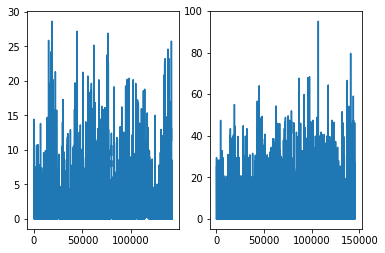

In [225]:
#compare
fr_hat = np.exp(X*np.matrix(result.x).T)/dt
fr_hat = np.array(fr_hat).flatten() #matrix can't be flattened
smooth_fr_hat = np.convolve(fr_hat,f,'same')
plt.subplot(121)
plt.plot(smooth_fr_hat)
plt.subplot(122)
plt.plot(smooth_fr)

In [ ]:
%debug

In [ ]:
%matplotlib inline
boxSize = 100
nbins = 20
bins = np.arange(boxSize/nbins,boxSize,boxSize/nbins)
xcoord = np.digitize(data['posx_c'],bins)
ycoord = np.digitize(data['posy_c'],bins)
coord = (xcoord)*nbins+(nbins-ycoord) #make x and y start form the top left corner
coord[1:40]

In [25]:
import matplotlib.pylab as plt


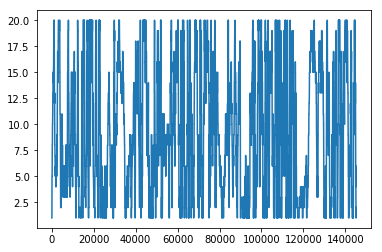

In [26]:
plt.plot(a)